# Цель работы
1. Проанализировать данные на наличие аномалий и полезности информации
2. Построить модели машинного обучения для классификации пассажиров
3. Сравнить модели и сделать вывод по проделанной работе

In [1]:
# Для работы с датасетом
import numpy as np
import pandas as pd

# Для отрисовки графиков
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder # Класс для кодирования данных
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Для работы с нейронными сетями
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

C:\Users\denis\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Предобработка данных

In [2]:
df = pd.read_csv('train.csv')
print(len(df), 'x', len(df.T))
df.head()

891 x 12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Загрузим датасет с данными о том, кто из пассажиров выжил

## Работа с пустыми значениями

<AxesSubplot:>

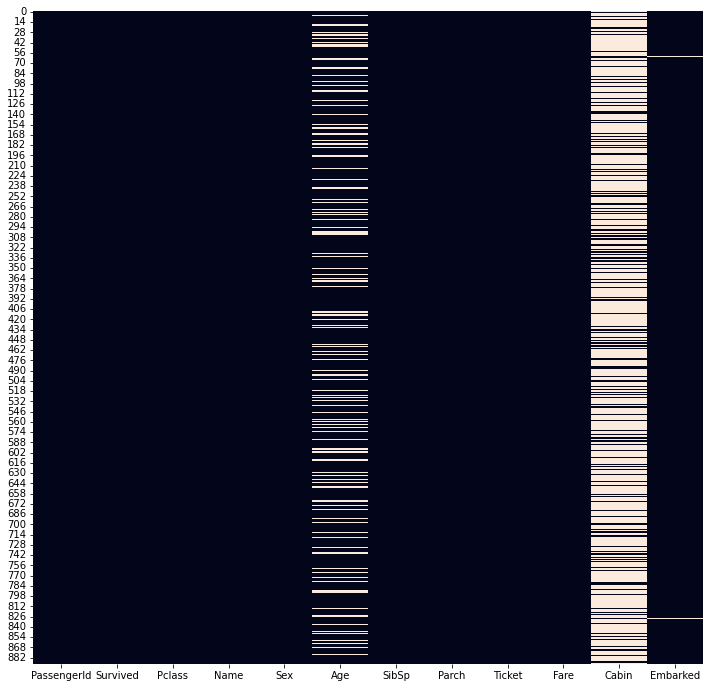

In [3]:
# Строим график, чтобы посмотреть нулевые значения в столбцах
plt.figure(figsize = (12,12))
sns.heatmap(df.isnull(), cbar=False)

Удалим столбцы "Age" и "Cabin" так как в них слишком много пустых значений и строки, где пропущено значение столбца "Embarked"

In [4]:
df.drop(['Age', 'Cabin'], inplace = True, axis = 1) # Удаляем ненужные столбцы
df.dropna(inplace = True) # Удаляем 2 строки с пустыми значениями
df = df.reset_index(drop = True) # Сбрасываем индексы

Заменим пустые значения в столбце 'Fare' средним значением по столбцу

In [5]:
df['Fare'][df['Fare'].isnull()] = df['Fare'].mean()

C:\Users\denis\AppData\Local\Temp/ipykernel_11072/3854949949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fare'][df['Fare'].isnull()] = df['Fare'].mean()


<AxesSubplot:>

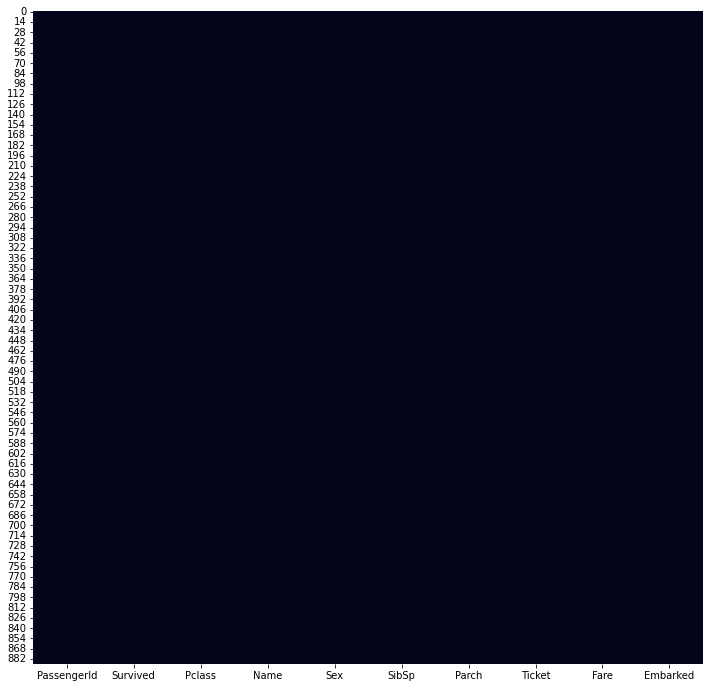

In [6]:
# Строим еще раз график, чтобы убедиться в отсутствии пустых значений
plt.figure(figsize = (12,12))
sns.heatmap(df.isnull(), cbar=False)

## Работа с категориальными данными

In [7]:
# Найдем полезные категориальные данные
obj_df = df.select_dtypes(include = ['object']).copy() # Выбираем данные типа "object"
for column in obj_df: # Идем по данным типа "object"
    print(f'{column} -', len(obj_df[column].unique()), 'уникальных значений в столбце')

Name - 889 уникальных значений в столбце
Sex - 2 уникальных значений в столбце
Ticket - 680 уникальных значений в столбце
Embarked - 3 уникальных значений в столбце


In [8]:
# Удалим номера билетов и имена пассажиров, так как эти данные не несут в себе полезной информации
df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


Закодирум столбцы "Sex" и "Embarked" в числовой формат

In [9]:
ord_enc = OrdinalEncoder()
df['Sex'] = ord_enc.fit_transform(df[['Sex']])
df['Embarked'] = ord_enc.fit_transform(df[['Embarked']])
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,1.0,1,0,7.2500,2.0
1,1,1,0.0,1,0,71.2833,0.0
2,1,3,0.0,0,0,7.9250,2.0
3,1,1,0.0,1,0,53.1000,2.0
4,0,3,1.0,0,0,8.0500,2.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   Embarked  889 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 48.7 KB


## Работа с выбросами

Survived


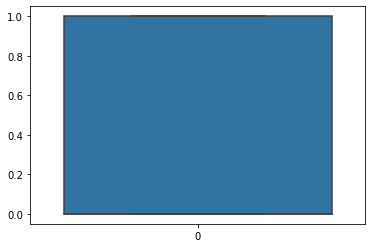

Pclass


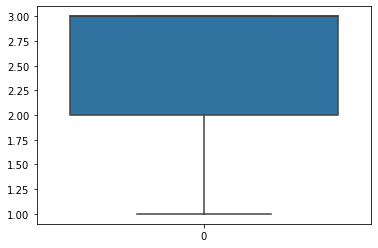

Sex


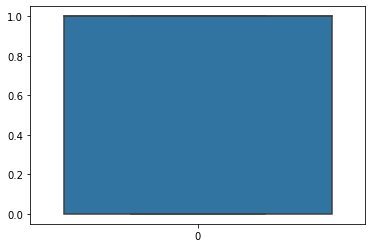

SibSp


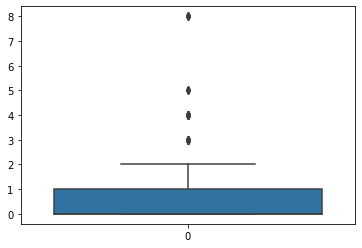

Parch


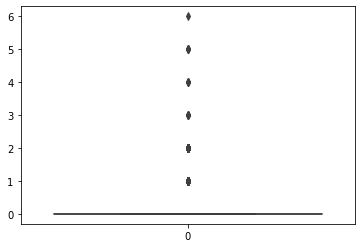

Fare


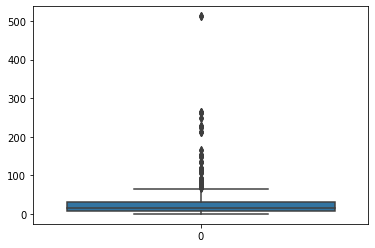

Embarked


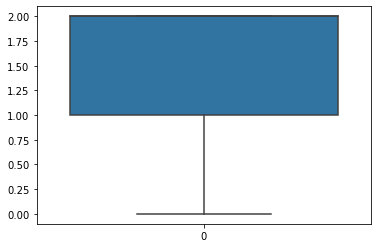

In [11]:
# Отобразим графики, чтобы узнать какие атрибуты имеют выбросы
for column in df:
    print(column)
    sns.boxplot(data = df[column])
    plt.show()

Необходимо удалить выбросы из столбцов "Fare", "SibSp", и "Parch"

Для этого найдем первый и третий квартили

In [12]:
for column in ["Fare", "SibSp", "Parch"]:
    Q1 = df[column].quantile(0.25) # Первый квартиль
    Q3 = df[column].quantile(0.75) # Третий квартиль
    IQR = Q3 - Q1 # Межквартильный диапазон  
    df = df.loc[(df[column] >= Q1-1.5*IQR ) & (df[column] <= Q3+1.5*IQR)] # Удаляем выбросы

df = df.reset_index(drop = True) # Сбрасываем индексы

Так как при изменении выбросов на самое частое значение в столбце "Parch" получилось только одно значение, то удалим его, так как он не несет полезной информации

In [13]:
df.drop(['Parch'], inplace = True, axis = 1)

## Нормализация данных

Нормализуем все данные

In [14]:
for column in df:
    maximum = df[column].max()
    minimum = df[column].min()
    for i in range(len(df[column])):
        df[column][i] = (maximum - df[column][i])/(maximum - minimum)
df.head()

C:\Users\denis\AppData\Local\Temp/ipykernel_11072/2935175220.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = (maximum - df[column][i])/(maximum - minimum)


,Survived,Pclass,Sex,SibSp,Fare,Embarked
0,1,0,0.0,0,0.881488,0.0
1,0,0,1.0,1,0.870454,0.0
2,0,1,1.0,0,0.131998,0.0
3,1,0,0.0,1,0.868410,0.0
4,1,0,0.0,1,0.861736,0.5


# Машинное обучение

## Подготовка данных

Заранее загрузим тестовые данные

In [15]:
# Тестовые данные
df_test = pd.read_csv('test.csv')
print(len(df_test), 'x', len(df_test.T))

# Ответы на тестовые данные
df_sex = pd.read_csv('gender_submission.csv')
print(len(df_sex), 'x', len(df_sex.T))

# Объеденим датасеты
df_test = pd.merge(df_test, df_sex)
df_test.head()

418 x 11
418 x 2


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


Проведем предобработку данных, которая была проделана для обучающих данных

In [16]:
# Удаление лишних столбцов
NOT_DEL = {'Survived', 'Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked'} # Столбцы, которые останутся
for column in df_test: # Цикл по столбцам
    if column not in NOT_DEL:
        df_test.drop(column, axis = 1, inplace = True)
        
# Удаление строк с пустыми значениями
df_test.dropna(inplace = True)
df_test = df.reset_index(drop = True) # Сбрасываем индексы

# Кодировка категориальных данных
ord_enc = OrdinalEncoder()
df_test['Sex'] = ord_enc.fit_transform(df_test[['Sex']])
df_test['Embarked'] = ord_enc.fit_transform(df_test[['Embarked']])

# Нормализация данных
for column in df_test:
    maximum = df_test[column].max()
    minimum = df_test[column].min()
    for i in range(len(df_test[column])):
        df_test[column][i] = (maximum - df_test[column][i])/(maximum - minimum)
df_test.head()

C:\Users\denis\AppData\Local\Temp/ipykernel_11072/1980897123.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[column][i] = (maximum - df_test[column][i])/(maximum - minimum)


,Survived,Pclass,Sex,SibSp,Fare,Embarked
0,0,1,1.0,1,0.118512,1.0
1,1,1,0.0,0,0.129546,1.0
2,1,0,0.0,1,0.868002,1.0
3,0,1,1.0,0,0.131590,1.0
4,0,1,1.0,0,0.138264,0.5


Тестовые данные готовы к работе

In [17]:
# Разделим обучающие и тестовые данные на входные и ответы
x_train = df[['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked']]
y_train = df['Survived']

x_test = df_test[['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked']]
y_test = df_test['Survived']

## Дерево решений

In [18]:
from sklearn.tree import DecisionTreeClassifier # Импортируем модель дерева решений

classifier = DecisionTreeClassifier()
classifier = classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print('Точность алгоритма:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Точность алгоритма: 0.8056013179571664
[[390  38]
 [ 80  99]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       428
           1       0.72      0.55      0.63       179

    accuracy                           0.81       607
   macro avg       0.78      0.73      0.75       607
weighted avg       0.80      0.81      0.80       607



## К-ближайших соседей

In [19]:
from sklearn.neighbors import KNeighborsClassifier # Импортируем модель К-ближайших соседей

classifier = KNeighborsClassifier()
classifier = classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print('Точность алгоритма:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Точность алгоритма: 0.7413509060955519
[[384  44]
 [113  66]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       428
           1       0.60      0.37      0.46       179

    accuracy                           0.74       607
   macro avg       0.69      0.63      0.64       607
weighted avg       0.72      0.74      0.72       607



## Метод опорных векторов

In [20]:
from sklearn.svm import SVC # Импортируем метод опорных векторов

classifier = SVC(kernel='linear')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print('Точность алгоритма:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Точность алгоритма: 0.8121911037891268
[[387  41]
 [ 73 106]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       428
           1       0.72      0.59      0.65       179

    accuracy                           0.81       607
   macro avg       0.78      0.75      0.76       607
weighted avg       0.81      0.81      0.81       607



## Нейронная сеть через PyTorch

In [21]:
class Titan(nn.Module):
    def __init__(self):
        super(Titan, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 1)
    def forward(self, x):
        x = x.reshape(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)

In [22]:
titan = Titan()

# Осуществляем оптимизацию путем стохастического градиентного спуска
optimizer = torch.optim.SGD(titan.parameters(), lr=0.01, momentum=0.9)

# Создаем функцию потерь
criterion = nn.BCELoss()


epochs = 5 # Количество эпох
log_interval = 303 # интервал отслеживания процесса
running_loss = 0 # Для вычисления величины ошибок

# Подготовка тренировочных данных для модели
torch_tensor_train = torch.tensor(x_train[['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked']].values)
torch_tensor_target = torch.tensor(y_train.values)
data, target = Variable(torch_tensor_train.float()), Variable(torch_tensor_target.float())

# Запускаем главный тренировочный цикл
for epoch in range(epochs): # Цикл по эпохам
    for i in range(len(torch_tensor_train)): # Цикл по тренировочным данным
        optimizer.zero_grad()
        titan_out = titan(data[i])
        loss = criterion(titan_out[0][0], target[i])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % log_interval == 0 or i == len(torch_tensor_train)-1: # Вывод сообщения для отслеживания прогресса
            print('Train Epoch: {} [{}/{} ({:.0f}%)]tLoss: {:.6f}'.format(
                   epoch, len(data) - (len(data) - i), len(torch_tensor_train)-1,
                          100 * i / len(x_train), loss.data))

Train Epoch: 0 [0/606 (0%)]tLoss: 0.825637
Train Epoch: 0 [303/606 (50%)]tLoss: 0.546122


C:\Users\denis\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [606/606 (100%)]tLoss: 0.075800
Train Epoch: 1 [0/606 (0%)]tLoss: 0.109143
Train Epoch: 1 [303/606 (50%)]tLoss: 0.503204
Train Epoch: 1 [606/606 (100%)]tLoss: 0.073228
Train Epoch: 2 [0/606 (0%)]tLoss: 0.072580
Train Epoch: 2 [303/606 (50%)]tLoss: 0.505364
Train Epoch: 2 [606/606 (100%)]tLoss: 0.076986
Train Epoch: 3 [0/606 (0%)]tLoss: 0.061126
Train Epoch: 3 [303/606 (50%)]tLoss: 0.453872
Train Epoch: 3 [606/606 (100%)]tLoss: 0.067898
Train Epoch: 4 [0/606 (0%)]tLoss: 0.034301
Train Epoch: 4 [303/606 (50%)]tLoss: 0.441916
Train Epoch: 4 [606/606 (100%)]tLoss: 0.070563


In [23]:
# Подготовка тестовых данных, аналогично тренировочным данным
torch_tensor_test = torch.tensor(x_test[['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked']].values)
torch_tensor_target_test = torch.tensor(y_test.values)
test_data, test_target = Variable(torch_tensor_test.float()), Variable(torch_tensor_target_test.float())

titan.eval() # Переключение в режим оценки (evaluation mode) для модели

# Оценка модели на тестовых данных
with torch.no_grad():
    for i in range(len(x_test)):
        test_output = titan(test_data[i])
        test_loss = criterion(test_output[0][0], test_target[i])

# Расшифровка ответов модели и подсчет точности
predicted_classes = (test_output > 0.5).float()
accuracy = (predicted_classes == test_target).sum().item() / len(test_target)

# print(f"Ошибка: {test_loss.item()}")
print(f"Точность модели: {accuracy * 100} %")

Точность модели: 70.51070840197694 %


# Вывод
1. Были проанализированы исходные данные. Проведена работа с пустыми значениями, выявлены полезные категориальные данные, удалены выбросы, итоговые данные были нормализованы
2. Реализовано несколько алгоритмов машинного обучения: дерево решений, к-ближайших соседей, метод опорных векторов. Также реализована модель нейронной сети на основе библиотеки PyTorch
3. Все модели справились с заданием на хорошем уровне (70% - 81% точности). Лучше всего с задачей справился метод опорных векторов. Хуже всех - нейронная сеть. Для улучшения работы нейронной сети рекомендуется проводить эксперименты с изменнением архитектуры